# Self-supervised Monocular Depth Estimation 

As with semantic segmentation problems, lack of readily available accurate ground truth is a serious hinderance to the applocation of deep learning to monocular depth estimation. In this notebook, I will explore the self-supervised monocolar depth estimation network proposed by Godard et. al in their 2017 paper titled "Unsupervised Monocular Depth Estimation with Left-Right Consistency" (https://arxiv.org/pdf/1609.03677v3.pdf). The official repository, dubbed "Monodepth" was referenced in creating this notebook. https://github.com/mrharicot/monodepth

<img src="images/monodepth.png">

The goal for the convolutional network is to predict the disparity map between the left and right image using just the left image as an input. Once we have estimated the disparity map, we can trivially reconstruct the depth using camera intrinsic / extrinsic parameters. 

$\hat d=bf/d$ where $\hat d$ = depth, b = baseline distance, f = focal length, d = disparity

The network uses the left image to predict both the left to right disparity map (how to reconstruct the right image using the left image) but also the right to left disparity map (how to reconstruct the left image using the right image). During training, we can then enforce consistency between the two disparity maps, leading to fewer artifacts in the final image. We also then get to use two ground truths: during training, we can "create" a proposed right image using the disparity map and the left image AND we can create a proposed left image in the same way. We then compare the proposed images to the actual images as a component of our loss function, allowing us to use both images as a component to our training loss instead of just one. (eg if we reconstructed the right image using the left image)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import os
import random
import copy
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from torch.utils.data import Dataset

In [2]:
device = 'cuda:1'
train_dir = 'data/train'
val_dir = 'data/val'

print(torch.cuda.is_available())

True


# Dataset

We will use a small subset of the KITTI dataset:

Training (5268 left/right pairs):
```
https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0004/2011_09_29_drive_0004_sync.zip
https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_30_drive_0016/2011_09_30_drive_0016_sync.zip
https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0027/2011_10_03_drive_0027_sync.zip
```

Validation: (1059 left/right pairs)
```
https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0071/2011_09_29_drive_0071_sync.zip
```

The files should be extracted to a folder (default `data/train` and `data/val`) with the following structure:

```
data
├── train
│   ├── 2011_09_26_drive_0001_sync
│   │   ├── image_02
│   │   │   ├─ data
│   │   │   │   ├── 0000000000.png
│   │   │   │   └── ...
│   │   ├── image_03
│   │   │   ├── data
│   │   │   │   ├── 0000000000.png
│   │   │   │   └── ...
│   ├── ...
├── val
│   ├── 2011_09_26_drive_0001_sync
│   │   ├── image_02
│   │   │   ├─ data
│   │   │   │   ├── 0000000000.png
│   │   │   │   └── ...
│   │   ├── image_03
│   │   │   ├── data
│   │   │   │   ├── 0000000000.png
│   │   │   │   └── ...
│   ├── ...
```

The dataloader will look for left images in `image_02` and right iamges in `image_03`

## Transformations

I will use three transformations during training:
- Resize to 256x512 (expected input size)
- Random flip
- Randomly augment image colour, gamma, and brightness

In [3]:
# Create joint transformations for a  sample containing either a (left_image, right_image) or a just a left_image

class JointToTensor(object):
    def __call__(self, sample):
        if isinstance(sample, list) or isinstance(sample, tuple):
            return tF.to_tensor(sample[0]), tF.to_tensor(sample[1])
        else:
            return tF.to_tensor(sample)
    
class JointRandomFlip(object):
    def __call__(self, sample):
        if random.random() > 0.5:
            if isinstance(sample, list) or isinstance(sample, tuple):
                return tF.hflip(sample[0]), tF.hflip(sample[1])
            else:
                return tF.hflip(sample)
        else:
            return sample
        
class JointResize(object):
    def __init__(self, size=(256, 512)):
        self.resize = transforms.Resize(size)
        
    def __call__(self, sample):
        if isinstance(sample, list) or isinstance(sample, tuple):
            return self.resize(sample[0]), self.resize(sample[1])
        else:
            return self.resize(sample)

class JointRandomAugment(object):
    def __init__(self, gamma_low=0.8, gamma_high=1.3, 
                       brightness_low=0.5, brightness_high=2.0, 
                       color_low=0.8, color_high=1.2):
        self.gamma_low = gamma_low
        self.gamma_high = gamma_high
        self.brightness_low = brightness_low
        self.brightness_high = brightness_high
        self.color_low = color_low
        self.color_high = color_high
        
    def __call__(self, sample):
        # Only augment during training (with a pair left right) - really doesnt make sense otherwise.
        if isinstance(sample, list) or isinstance(sample, tuple):
            # randomly shift gamma
            random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
            left_image_aug = sample[0] ** random_gamma
            right_image_aug = sample[1] ** random_gamma
            
            # randomly shift brightness
            random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
            left_image_aug = left_image_aug * random_brightness
            right_image_aug = right_image_aug * random_brightness
            
            # randomly shift color
            random_colors = np.random.uniform(self.color_low, self.color_high, 3)
            for i in range(3):
                left_image_aug[i, :, :] *= random_colors[i]
                right_image_aug[i, :, :] *= random_colors[i]
                
            # saturate
            left_image_aug = torch.clamp(left_image_aug, 0, 1)
            right_image_aug = torch.clamp(right_image_aug, 0, 1)

            return left_image_aug, right_image_aug
        else:
            return sample

data_transforms = {
    'train': transforms.Compose([JointToTensor(), JointResize(), JointRandomAugment(), JointRandomFlip()]),
    'val': transforms.Compose([JointToTensor(), JointResize()]),
    'test': transforms.Compose([JointToTensor(), JointResize()])
}

In [4]:
import os
from PIL import Image

def fnames_in_dir(dir):
    return sorted([os.path.join(dir, file) for file in os.listdir(dir)])

class KittiDataset(Dataset):
    """Sample of images from the KITTI dataset

    Args:
        root (string): Root directory of the Kitti Dataset
        mode (bool): Whether to run in 'train' or 'test' mode
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transforms (callable, optional): A function/transform that takes in either 
            an image or a (left_image, right_image) tuple and returns a transformed version.
    """
    def __init__(self, root, mode, transform=None):
        self.left_images = fnames_in_dir(os.path.join(root, 'image_02/data/'))
        
        if mode == 'train':
            self.right_images = fnames_in_dir(os.path.join(root, 'image_03/data/'))
            assert len(self.right_images) == len(self.left_images)
        
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        left_image = Image.open(self.left_images[idx])
        if self.mode == 'train':
            right_image = Image.open(self.right_images[idx])
            
            if self.transform:
                return self.transform((left_image, right_image))
            
            return left_image, right_image
        else:
            if self.transform:
                left_image = self.transform(left_image)
            return left_image

In [5]:
from torch.utils.data import DataLoader, ConcatDataset

# Prepare datasets
def create_dataset(root, mode, transform = None):
    data_dirs = os.listdir(root)
    mode = 'train'
    datasets = [KittiDataset(os.path.join(root, data_dir), mode, transform = transform) for data_dir in data_dirs]
    dataset = ConcatDataset(datasets)
    n_img = len(dataset)
    print('Use a dataset with', n_img, 'images')
    
    if mode == 'train':
        loader = DataLoader(dataset, batch_size=24, num_workers=4, shuffle=True)#, pin_memory=True)
    else:
        loader = DataLoader(dataset, batch_size=16, num_workers=4, shuffle=False)#, pin_memory=True)
    return loader

train_loader = create_dataset(train_dir, 'train', data_transforms['train'])
val_loader = create_dataset(val_dir, 'train', data_transforms['val'])

Use a dataset with 5268 images
Use a dataset with 1059 images


Developing on 1 images


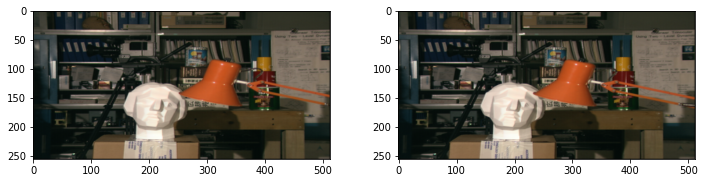

In [6]:
# For now, develop on a really small subset
#'data/train/2011_09_28_drive_0001_sync'
val_dataset = KittiDataset(val_dir + '/2011_09_29_drive_0071_sync', 'train', transform=data_transforms['val'])
test_dataset = KittiDataset('data/devel', 'train', transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=True)
print("Developing on", len(test_dataset), "images")
left, right = test_dataset[0]
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(left.permute(1, 2, 0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(right.permute(1, 2, 0))

# The Model

MonoDepth uses a standard encoder - decoder architecture. The encoder is from ResNet18 with four skip connections from the Resnet18's encoder activation blocks to achieve higher resolution outputs. The decoder outputs disparity estimates at four resolutions wich each scale doubling in resolution. The network also produces two outputs, the left to right disparity map and right to left disparity map. The full architecture is shown below. (Taken from the paper: https://arxiv.org/pdf/1609.03677v3.pdf)


<img src="images/model.png">

In [7]:
# Helper blocks adapted from https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L161
class iconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(iconv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_base = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=kernel_size, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1)/2))
        p2d = (p, p, p, p)
        x = self.conv_base(F.pad(x, p2d))
        x = self.normalize(x)
        return F.elu(x, inplace=True)

class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = iconv(num_in_layers, num_out_layers, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

class disp(nn.Module):
    def __init__(self, num_in_layers):
        super(disp, self).__init__()
        self.conv1 = nn.Conv2d(num_in_layers, 2, kernel_size=3, stride=1)
        self.normalize = nn.BatchNorm2d(2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        p = 1
        p2d = (p, p, p, p)
        x = self.conv1(F.pad(x, p2d))
        x = self.normalize(x)
        # Maximum disparity of 1/3 the image
        return 0.3 * self.sigmoid(x)
    

In [8]:
import torchvision.models as models

# TorchVision's version of Resnet18 seems to be slightly different from the one that MonoDepth used. 
# (fewer encoding layers) with faster downsampling. As such, the model is *slightly* different from the paper

class MyNet(nn.Module):
    def __init__(self, criterion=None):
        super(MyNet, self).__init__()
        
        self.criterion = criterion
        
        self.resnet = models.resnet18(pretrained=True)
        
        # Additional encoder layer as per the paper. Standard resnet block.
        self.layer5 = nn.Sequential(models.resnet.BasicBlock(512, 512, stride=(2, 2), downsample=nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            )), models.resnet.BasicBlock(512, 512))
        
        # Define decoder layers
        self.upconv7 = upconv(512, 512, 3, 2)
        self.iconv7 = iconv(512 + 512, 512, 3, 1)
        
        self.upconv6 = upconv(512, 512, 3, 2)
        self.iconv6 = iconv(256 + 512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = iconv(128 + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(64 + 128, 128, 3, 1)
        self.disp4_layer = disp(128)

        self.upconv3 = upconv(128, 64, 3, 1)
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.disp3_layer = disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.disp2_layer = disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = disp(16)

    def forward(self, left, right = None):

        # encoder
        skip1 = self.resnet.conv1(left)# H/2   -   64D
        x = self.resnet.bn1(skip1)
        x = self.resnet.relu(x)           # H/4   -   64D
        skip2 = self.resnet.maxpool(x)
        skip3 = self.resnet.layer1(skip2) # H/8   -   64D
        skip4 = self.resnet.layer2(skip3) # H/16  -   128D
        skip5 = self.resnet.layer3(skip4) # H/32  -   256D
        skip6 = self.resnet.layer4(skip5) # H/64  -   512D
        x = self.layer5(skip6)            # H/128 -   512D

        # decoder     
        x = self.upconv7(x)
        x = torch.cat((x, skip6), 1)
        x = self.iconv7(x)     # H / 64 - 512D
        
        x = self.upconv6(x)
        x = torch.cat((x, skip5), 1)
        x = self.iconv6(x)     # H / 32 - 512D

        x = self.upconv5(x)
        x = torch.cat((x, skip4), 1)
        x = self.iconv5(x)     # H / 16 - 256D

        x = self.upconv4(x)
        x = torch.cat((x, skip3), 1)
        x = self.iconv4(x)     # H / 8 - 128D
        disp4 = self.disp4_layer(x)
        udisp4 = nn.functional.interpolate(disp4, scale_factor=1, mode='bilinear', align_corners=True)
        disp4 = nn.functional.interpolate(disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        x = self.upconv3(x)
        x = torch.cat((x, skip2, udisp4), 1)
        x = self.iconv3(x)
        disp3 = self.disp3_layer(x)
        udisp3 = nn.functional.interpolate(disp3, scale_factor=2, mode='bilinear', align_corners=True)

        x = self.upconv2(x)
        x = torch.cat((x, skip1, udisp3), 1)
        x = self.iconv2(x)
        disp2 = self.disp2_layer(x)
        udisp2 = nn.functional.interpolate(disp2, scale_factor=2, mode='bilinear', align_corners=True)

        x = self.upconv1(x)
        x = torch.cat((x, udisp2), 1)
        x = self.iconv1(x)
        disp1 = self.disp1_layer(x)
        
        if self.training:
            # Return the loss if in training mode
            return self.criterion([disp1, disp2, disp3, disp4], [left, right])              
        else:
            # Return the actual prediction otherwise
            return disp1




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3137: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


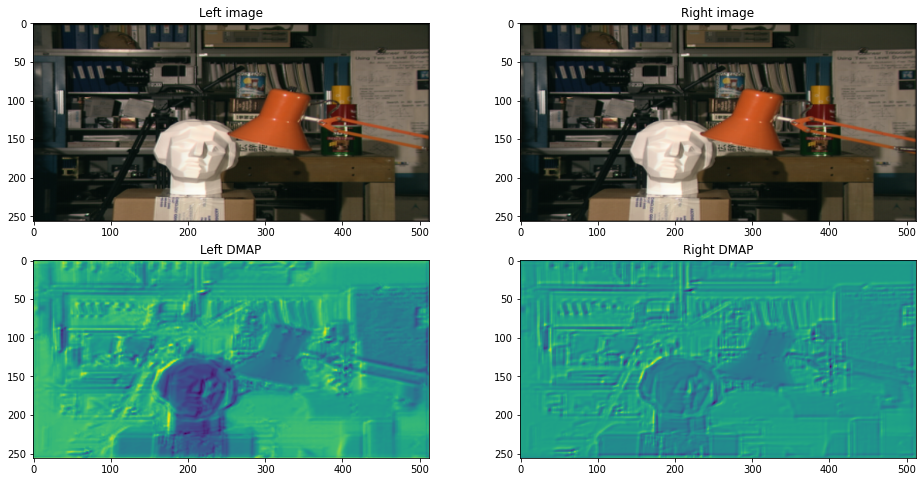

In [9]:

# Test the untrained network on some sample images
def test_images(net, dataset, i=0, draw=True):
    net.eval()
    sample = dataset[i]
    output = net.forward(sample[0][None].to(device)).to('cpu').detach()
    
    dmap_L = output[:,0,:,:].unsqueeze(1)
    dmap_R = output[:,1,:,:].unsqueeze(1)
    
    if draw:
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,2,1)
        plt.title('Left image')
        ax.imshow(sample[0].permute(1, 2, 0))
        ax = fig.add_subplot(2,2,2)
        plt.title('Right image')
        ax.imshow(sample[1].permute(1, 2, 0))
        ax = fig.add_subplot(2,2,3)
        plt.title('Left DMAP')
        ax.imshow(dmap_L[0][0])
        ax = fig.add_subplot(2,2,4)
        plt.title('Right DMAP')
        ax.imshow(dmap_R[0][0])
    
    return output, sample

untrained_net = MyNet().eval().to(device)
test_images(untrained_net, test_dataset)

pass

# Losses

The tricky part for this network will be generating proper losses as the loss function is relatively complex. The loss function is comprised of three components: Appearance Matching $C_{ap}$, Disparity Smoothness $C_{ds}$, and Left-right consistency $C_{lr}$. There are two pairs of each cost, one for the left disparity map and one for the right disparity map. Overall:
$$C_s = \alpha_{ap}(C_{ap}^l + C_{ap}^r) + \alpha_{ds}(C_{ds}^l + C_{ds}^r) + \alpha_{lr}(C_{lr}^l + C_{lr}^r)$$

This loss is applied at each scale

In [10]:
# Using a left image and a left->right disparity map, recreate the right image
def generate_image(img, dmap):
    """
    args:
        img: tensor of size [batch_size, channels, height, width]
        dmap: tensor of size [batch_size, channels, height, width]
    """
    
    batch_size, channels, height, width = img.shape
    
    # channels should be 0.
    dmap = dmap[:, 0, :, :].to(device)
    
    # pixel positions normalized to [0, 1]
    meshy, meshx = torch.meshgrid((torch.linspace(0, 1, height), torch.linspace(0, 1, width)))
    meshx = meshx.repeat(batch_size, 1, 1).to(device)
    meshy = meshy.repeat(batch_size, 1, 1).to(device)
    
    flowfield = torch.stack((meshx + dmap, meshy), dim=3).type_as(img)
    return F.grid_sample(img, 2 * flowfield - 1, mode='bilinear', padding_mode='zeros')

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3398: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imsh

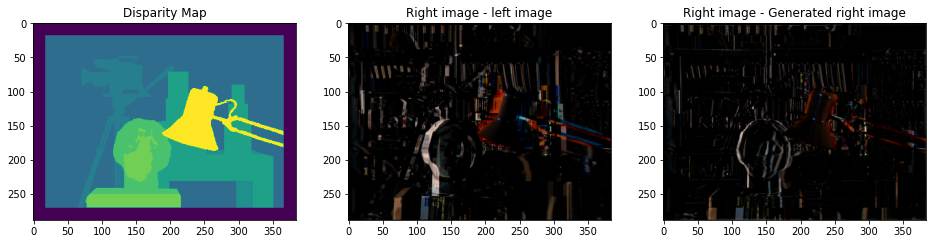

In [11]:
im_left = tF.to_tensor(image.imread("images/scene1.row3.col3.ppm"))
im_gt = torch.from_numpy(image.imread("images/truedisp.row3.col3.pgm") / 16)
im_gt = im_gt / im_gt.shape[0]
im_right = tF.to_tensor(image.imread("images/scene1.row3.col4.ppm"))

generated = generate_image(im_left[None], im_gt[None, None])

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,3,1)
plt.title('Disparity Map')
ax.imshow(im_gt)
ax = fig.add_subplot(1,3,2)
plt.title('Right image - left image')
ax.imshow((im_right - im_left).permute(1, 2, 0))
ax = fig.add_subplot(1,3,3)
plt.title('Right image - Generated right image')
ax.imshow(im_right.permute(1, 2, 0) - generated[0].permute(1, 2, 0))

## Appearance Matching Loss

The appearance matching loss compares the reconstructed image to the origional image. It uses a combination of an l1 normand a single scale Structural Similarity Index Measure on the difference in intensity 

$$\frac{1}{N} \sum_{ij} \alpha \frac{1 - SSIM(I_{ij}, \tilde I_{ij})}{2} + (1-\alpha) || I_{ij} - \tilde I_{ij} ||$$


In [12]:
class AppearanceMatchingLoss(nn.modules.Module):
    def __init__(self, alpha = 0.85):
        super(AppearanceMatchingLoss, self).__init__()
        self.alpha = alpha

    # Simplified Structural Similarity Index Measure (SSIM) adapted from 
    # https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L91
    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
        
    def forward(self, input, target):
        ssim = self.SSIM(input, target)
        ssim_loss = self.alpha * torch.mean(ssim)
        l1_loss = (1 - self.alpha) * torch.mean(torch.abs(input - target))
        return ssim_loss + l1_loss

In [13]:
AppearanceMatchingLoss()(im_right[None], generated)

tensor(0.1623)


## Disparity Smoothness Loss

The Disparity Smoothness Loss is a L1 penalty on gradient discontinuities, weighted by image gradients to avoid penalizing discontinuities at edges

$$\frac{1}{N} \sum_{ij} |\partial_x d_{ij}| e^{-|\partial_x I_{ij}||} + |\partial_y d_{ij}| e^{-|\partial_y I_{ij}||}$$


In [14]:
class DisparitySmoothnessLoss(nn.modules.Module):
    def __init__(self):
        super(DisparitySmoothnessLoss, self).__init__()
    
    # Compute x and y gradients
    def gradient_x(self, img):
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        return img[:, :, :, :-1] - img[:, :, :, 1:]
    def gradient_y(self, img):
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        return img[:, :, :-1, :] - img[:, :, 1:, :]  
    
    def forward(self, dmap, img):
        dmap_dx = torch.abs(self.gradient_x(dmap))
        dmap_dy = torch.abs(self.gradient_y(dmap))
        img_dx = torch.abs(self.gradient_x(img))
        img_dy = torch.abs(self.gradient_y(img))
        return torch.mean(dmap_dx * torch.exp(-torch.mean(img_dx, 1, keepdim=True)) + \
                dmap_dy * torch.exp(-torch.mean(img_dy, 1, keepdim=True)))

In [15]:
print(DisparitySmoothnessLoss()(im_gt[None, None], im_left[None]))
print(DisparitySmoothnessLoss()(im_left[None], im_gt[None, None]))

tensor(0.0006, dtype=torch.float64)
tensor(0.0545, dtype=torch.float64)



## Left-Right Disparity Consistency Loss

Standard L1 loss to enforce consistency between left disparity map and projected right disparity map

$$\frac{1}{N} \sum_{ij} |d^l_{ij} - d^r_{ij + d^l_{ij}}|$$

In [16]:
class LeftRightConsitencyLoss(nn.modules.Module):
    def __init__(self):
        super(LeftRightConsitencyLoss, self).__init__()
    
    def forward(self, dmap_left, dmap_right):
        dmap_right_proj = generate_image(dmap_right, -dmap_left)
        dmap_left_proj = generate_image(dmap_left, dmap_right)
        return torch.mean(torch.abs(dmap_right_proj  - dmap_left)) + \
                torch.mean(torch.abs(dmap_left_proj  - dmap_right))

In [17]:
LeftRightConsitencyLoss()(im_gt[None, None], im_gt[None, None])

tensor(0.0042, dtype=torch.float64)

# Combined Loss

$$C_s = \alpha_{ap}(C_{ap}^l + C_{ap}^r) + \alpha_{ds}(C_{ds}^l + C_{ds}^r) + \alpha_{lr}(C_{lr}^l + C_{lr}^r)$$

We set $\alpha_{ap} = \alpha_{lr} = 1$. 

As a result of our multi-scale output, the typical disparity of neighboring pixels will differ by a factor of two between each scale To correct for this, we scale the disparity smoothness term $\alpha_{ds}$ with r for each scale to get equivalent smoothing at each level. Thus $α_{ds} = 1/r$ where $r$ is the downscaling factor of the corresponding disparity map

In [18]:
def scale(img, scales):
    """
    args:
        img: [N, C, H, W] tensor to scale
        scales: list(float) scales at which to scale the image
    """
    images = []
    _, _, h, w = img.size()

    for scale in scales:
        new_size = [int(h * scale), int(w * scale)]
        images.append(F.interpolate(img, size=new_size, mode='bilinear', align_corners=True))
    return images

In [19]:
scales = scale(im_left[None], [1, 0.5, 0.25, 0.125])
print([t.shape for t in scales])

[torch.Size([1, 3, 288, 384]), torch.Size([1, 3, 144, 192]), torch.Size([1, 3, 72, 96]), torch.Size([1, 3, 36, 48])]


In [20]:
class MonoDepthLoss(nn.modules.Module):
    def __init__(self, device='cpu', alpha_ap = 1, alpha_ds = 1, alpha_lr = 1):
        super(MonoDepthLoss, self).__init__()
        self.alpha_ap = alpha_ap
        self.alpha_ds = alpha_ds
        self.alpha_lr = alpha_lr
        self.ap = AppearanceMatchingLoss().to(device)
        self.ds = DisparitySmoothnessLoss().to(device)
        self.lr = LeftRightConsitencyLoss().to(device)
    
    def pyramid_scale(self, img):
        return scale(img, [1, 0.5, 0.25, 0.125])
    
    def __call__(self, input, target):
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): The loss
        """
        
        dmap_L = [dmap[:, 0, :, :].unsqueeze(1) for dmap in input]
        dmap_R = [dmap[:, 1, :, :].unsqueeze(1) for dmap in input]
        
        im_L, im_R = target
        im_L_scaled = self.pyramid_scale(im_L)
        im_R_scaled = self.pyramid_scale(im_R)
        
        # Dmap has values [0,0.3]. Need to shift LEFT (negative) when using the left dmap
        im_L_reconstructed = [generate_image(im, -dmap) for im, dmap in zip(im_R_scaled, dmap_L)]
        im_R_reconstructed = [generate_image(im, dmap) for im, dmap in zip(im_L_scaled, dmap_R)]
        
        # Appearance matching loss
        ap_loss_L = [self.ap(input, target) for input, target in zip(im_L_reconstructed, im_L_scaled)]
        ap_loss_R = [self.ap(input, target) for input, target in zip(im_R_reconstructed, im_R_scaled)]
        
        self.ap_loss = self.alpha_ap * sum(ap_loss_L + ap_loss_R)
        
        # Disparity smoothness loss
        ds_loss_L = [self.ds(dmap_L[i], dmap_R[i]) / 2 ** i for i in range(4)]
        ds_loss_R = [self.ds(dmap_R[i], dmap_L[i]) / 2 ** i for i in range(4)]
        
        self.ds_loss = self.alpha_ds * sum(ds_loss_L + ds_loss_R)
        
        # Left Right Consistency Loss
        self.lr_loss = self.alpha_lr * sum([self.lr(L, R) for L, R in zip(dmap_L, dmap_R)])
        
        return self.ap_loss + self.ds_loss + self.lr_loss

In [21]:
# Random test data
test = [torch.stack((dmap[:,0], dmap[:,0]), dim=1) for dmap in MonoDepthLoss().pyramid_scale(im_gt[None, None])]
print(test[0].shape)
MonoDepthLoss()(test, [im_left[None], im_right[None]])

torch.Size([1, 2, 288, 384])


tensor(1.3256, dtype=torch.float64)

# Training

In [22]:
def train(train_loader, net, optimizer, loss_graph, other_graph = None):
    net.train()
    for i, data in enumerate(train_loader):
        
        left, right = data
        left = left.to(device)
        right = right.to(device)
        
        main_loss = net(left, right=right)
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
        loss_graph.append(main_loss.item()) #Populate this list to graph the loss
        if (other_graph):
            other_graph[0].append(net.criterion.ap_loss.item())
            other_graph[1].append(net.criterion.lr_loss.item())
            other_graph[2].append(net.criterion.ds_loss.item())
    
    return main_loss


# Overfit on one image pair

To verify my code is correct, overfit on the `test_loader` which is a dataset containing a single left right pair

Starting Training with #images:  16


<IPython.core.display.Javascript object>


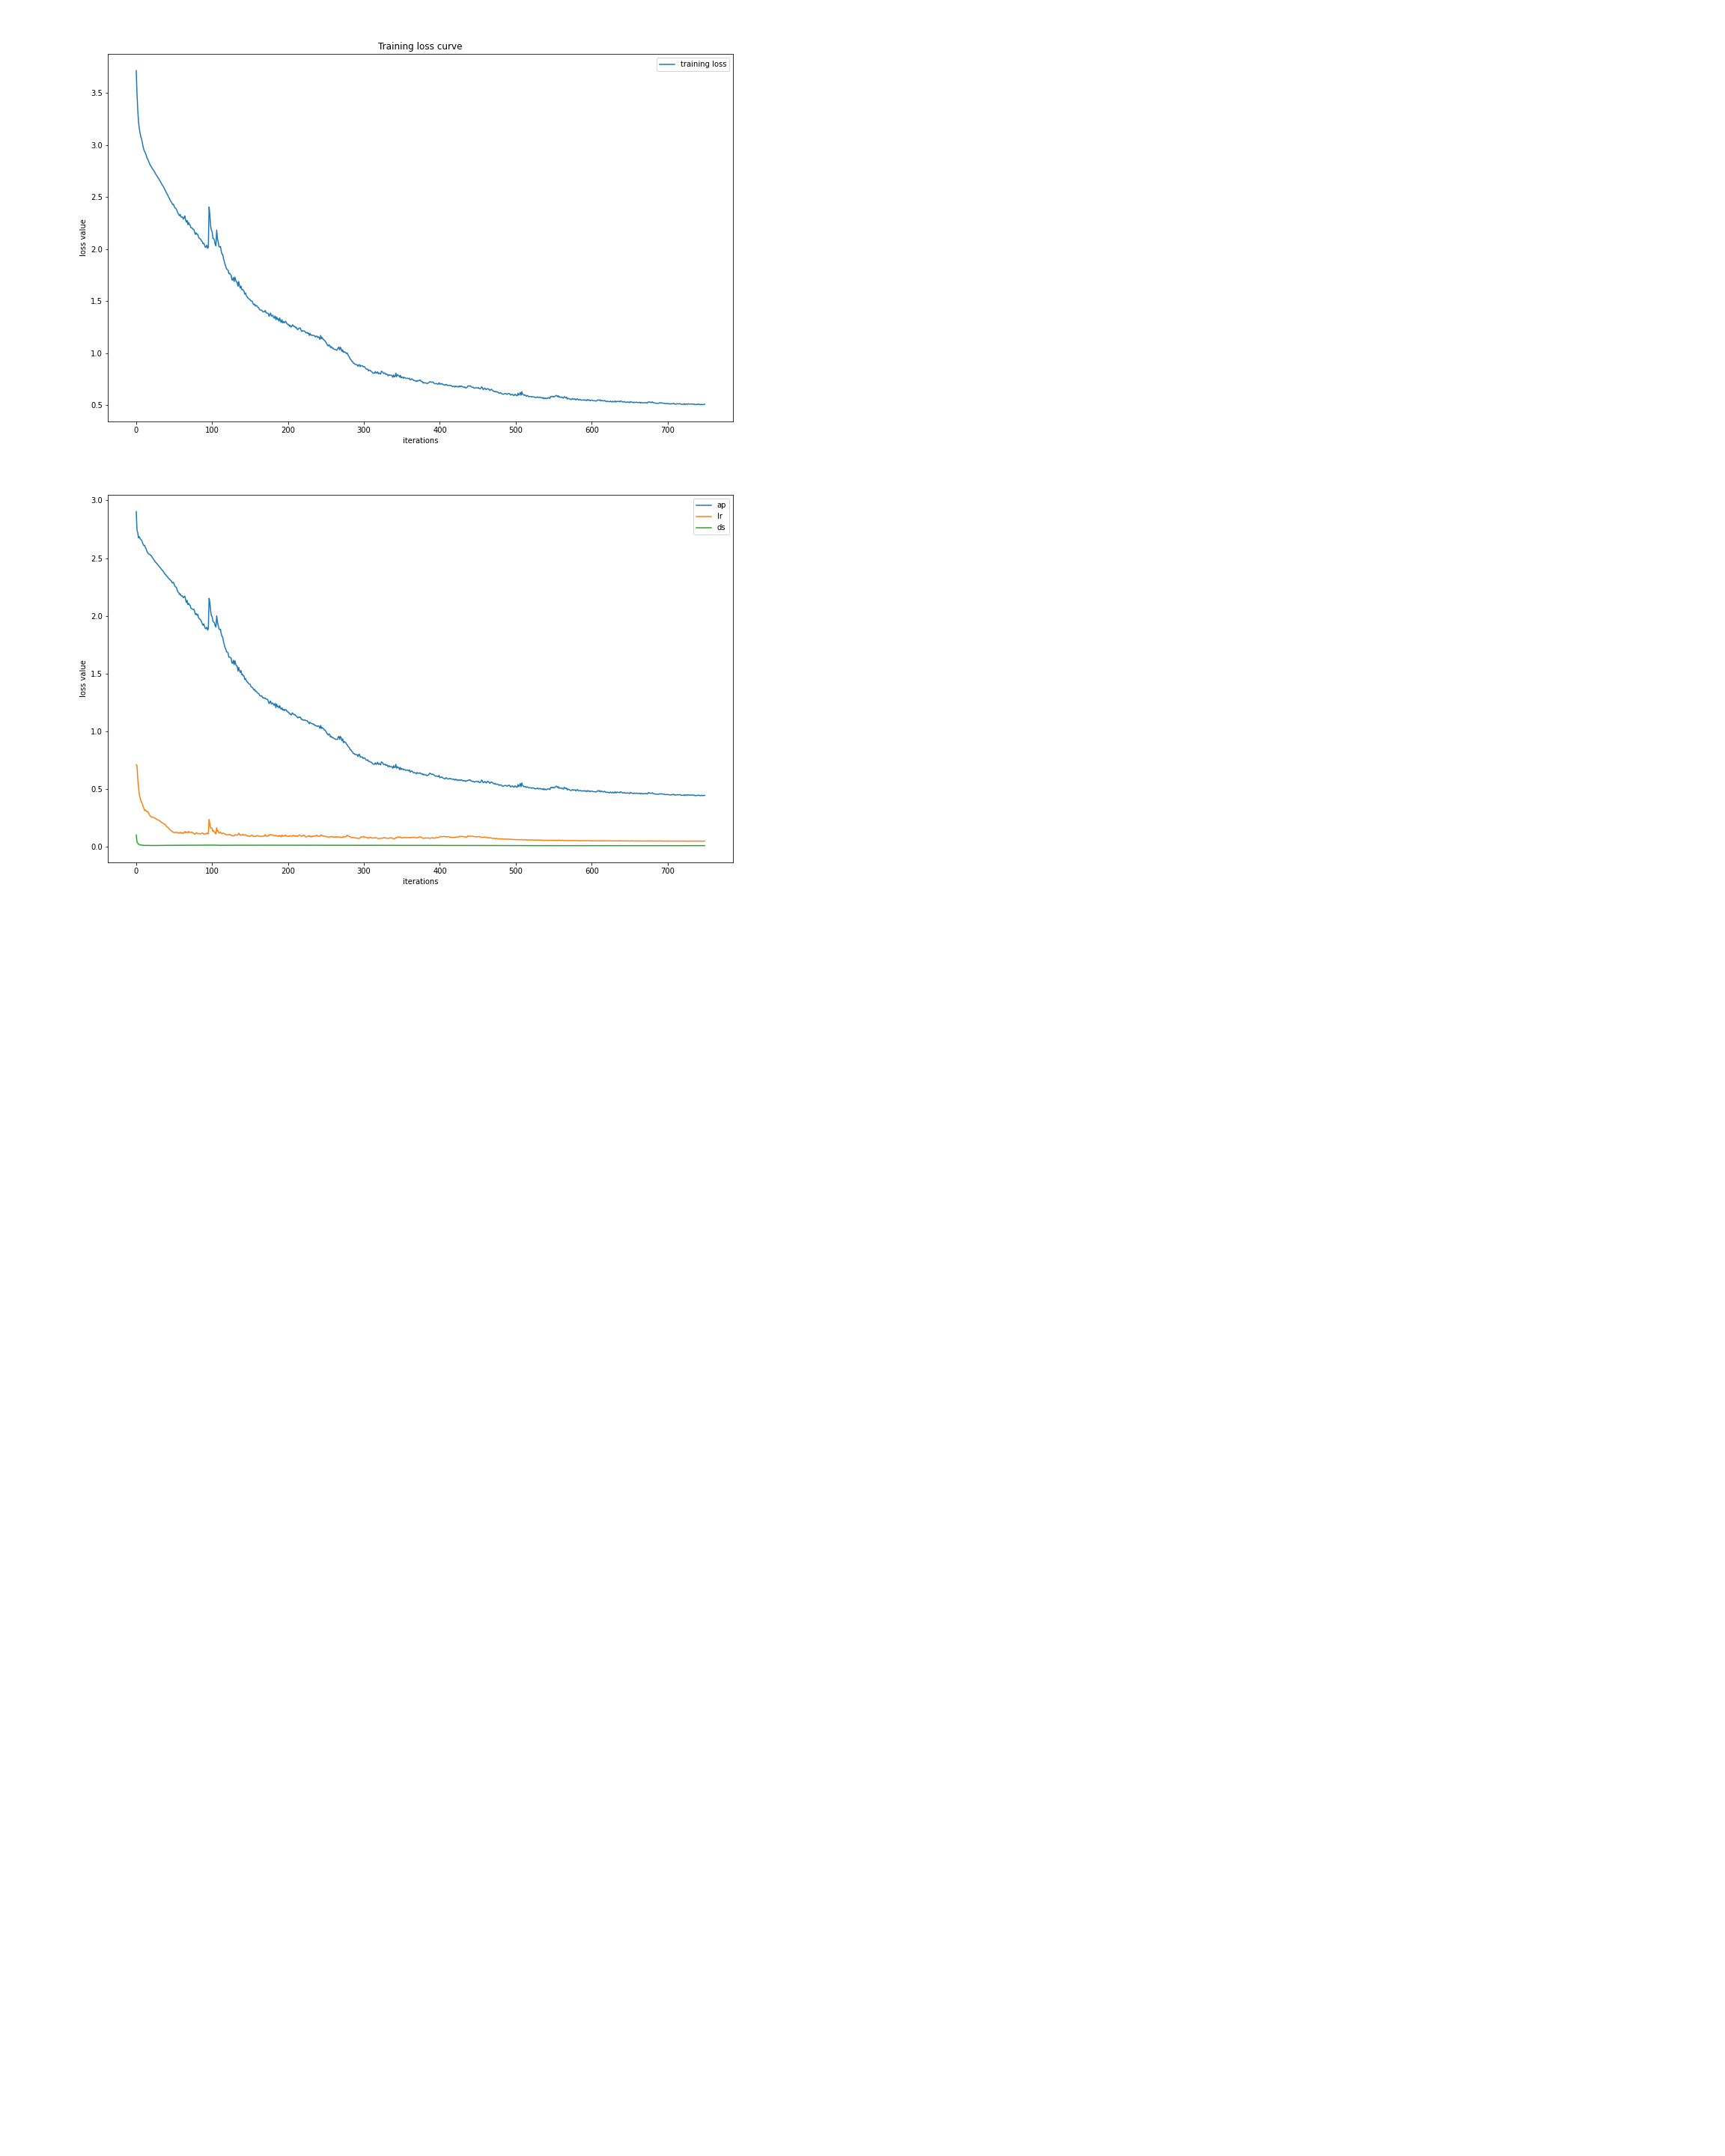

Epoch: 0 Loss: 3.7167587280273438
Epoch: 1 Loss: 3.4936580657958984
Epoch: 2 Loss: 3.3393714427948
Epoch: 3 Loss: 3.224429130554199
Epoch: 4 Loss: 3.161914587020874
Epoch: 5 Loss: 3.11777925491333
Epoch: 6 Loss: 3.0811946392059326
Epoch: 7 Loss: 3.0604119300842285
Epoch: 8 Loss: 3.024465560913086
Epoch: 9 Loss: 2.9890997409820557
Epoch: 10 Loss: 2.9573307037353516
Epoch: 11 Loss: 2.939241886138916
Epoch: 12 Loss: 2.925161838531494
Epoch: 13 Loss: 2.907823085784912
Epoch: 14 Loss: 2.879775047302246
Epoch: 15 Loss: 2.867783784866333
Epoch: 16 Loss: 2.8494555950164795
Epoch: 17 Loss: 2.8328256607055664
Epoch: 18 Loss: 2.815434455871582
Epoch: 19 Loss: 2.8016340732574463
Epoch: 20 Loss: 2.7913718223571777
Epoch: 21 Loss: 2.776319742202759
Epoch: 22 Loss: 2.768817901611328
Epoch: 23 Loss: 2.755540609359741
Epoch: 24 Loss: 2.7432425022125244
Epoch: 25 Loss: 2.7315309047698975
Epoch: 26 Loss: 2.7179510593414307
Epoch: 27 Loss: 2.707033157348633
Epoch: 28 Loss: 2.6967546939849854
Epoch: 29 Los

Epoch: 233 Loss: 1.1718710660934448
Epoch: 234 Loss: 1.171320915222168
Epoch: 235 Loss: 1.1684507131576538
Epoch: 236 Loss: 1.156535029411316
Epoch: 237 Loss: 1.1636829376220703
Epoch: 238 Loss: 1.1643974781036377
Epoch: 239 Loss: 1.1508111953735352
Epoch: 240 Loss: 1.1588844060897827
Epoch: 241 Loss: 1.1502101421356201
Epoch: 242 Loss: 1.1333938837051392
Epoch: 243 Loss: 1.170757532119751
Epoch: 244 Loss: 1.1410489082336426
Epoch: 245 Loss: 1.1509668827056885
Epoch: 246 Loss: 1.1350407600402832
Epoch: 247 Loss: 1.1331682205200195
Epoch: 248 Loss: 1.120384931564331
Epoch: 249 Loss: 1.1168993711471558
Epoch: 250 Loss: 1.1056983470916748
Epoch: 251 Loss: 1.0907862186431885
Epoch: 252 Loss: 1.0772855281829834
Epoch: 253 Loss: 1.0694094896316528
Epoch: 254 Loss: 1.0822184085845947
Epoch: 255 Loss: 1.072096347808838
Epoch: 256 Loss: 1.0550901889801025
Epoch: 257 Loss: 1.0649352073669434
Epoch: 258 Loss: 1.0496957302093506
Epoch: 259 Loss: 1.0528180599212646
Epoch: 260 Loss: 1.04050219058990

Epoch: 462 Loss: 0.655466616153717
Epoch: 463 Loss: 0.6612808108329773
Epoch: 464 Loss: 0.6544155478477478
Epoch: 465 Loss: 0.6529852151870728
Epoch: 466 Loss: 0.6421347260475159
Epoch: 467 Loss: 0.6493360996246338
Epoch: 468 Loss: 0.6542583703994751
Epoch: 469 Loss: 0.6460033655166626
Epoch: 470 Loss: 0.6388776898384094
Epoch: 471 Loss: 0.6361572742462158
Epoch: 472 Loss: 0.6306644678115845
Epoch: 473 Loss: 0.6348319053649902
Epoch: 474 Loss: 0.62790447473526
Epoch: 475 Loss: 0.6298659443855286
Epoch: 476 Loss: 0.6272061467170715
Epoch: 477 Loss: 0.6247467994689941
Epoch: 478 Loss: 0.6157696843147278
Epoch: 479 Loss: 0.6176928281784058
Epoch: 480 Loss: 0.6208444237709045
Epoch: 481 Loss: 0.6154822111129761
Epoch: 482 Loss: 0.6098145246505737
Epoch: 483 Loss: 0.6068909764289856
Epoch: 484 Loss: 0.6064720749855042
Epoch: 485 Loss: 0.6105656623840332
Epoch: 486 Loss: 0.6131976842880249
Epoch: 487 Loss: 0.6140622496604919
Epoch: 488 Loss: 0.6056568622589111
Epoch: 489 Loss: 0.605396807193

Epoch: 691 Loss: 0.5241257548332214
Epoch: 692 Loss: 0.5206933617591858
Epoch: 693 Loss: 0.5222164392471313
Epoch: 694 Loss: 0.5210853815078735
Epoch: 695 Loss: 0.5200974941253662
Epoch: 696 Loss: 0.5165642499923706
Epoch: 697 Loss: 0.5151619911193848
Epoch: 698 Loss: 0.5168463587760925
Epoch: 699 Loss: 0.5177711844444275
Epoch: 700 Loss: 0.518302857875824
Epoch: 701 Loss: 0.5128605365753174
Epoch: 702 Loss: 0.5154080986976624
Epoch: 703 Loss: 0.5136274695396423
Epoch: 704 Loss: 0.5124351978302002
Epoch: 705 Loss: 0.5147404670715332
Epoch: 706 Loss: 0.515169620513916
Epoch: 707 Loss: 0.5146751403808594
Epoch: 708 Loss: 0.519115149974823
Epoch: 709 Loss: 0.5125318765640259
Epoch: 710 Loss: 0.5108191967010498
Epoch: 711 Loss: 0.512305498123169
Epoch: 712 Loss: 0.5134066343307495
Epoch: 713 Loss: 0.5164474844932556
Epoch: 714 Loss: 0.5122019648551941
Epoch: 715 Loss: 0.5135811567306519
Epoch: 716 Loss: 0.5159549713134766
Epoch: 717 Loss: 0.5136478543281555
Epoch: 718 Loss: 0.5093728303909

In [24]:
%%time
%matplotlib notebook

overfit_net = MyNet()
overfit_net.to(device)

# set loss function for the net
overfit_net.criterion = MonoDepthLoss(device).to(device) # MonodepthLoss().to(device)
overfit_net.train()
loader = test_loader
optimizer = optimizer = torch.optim.Adam(overfit_net.parameters(), lr=0.01) #1e-4

EPOCH = 750

print("Starting Training with #images: ", len(loader) * loader.batch_size)

loss_graph = []
ap = []
lr = []
ds = []

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(2,1,1)
other = fig.add_subplot(2,1,2)

for e in range(EPOCH):
    loss = train(loader, overfit_net, optimizer, loss_graph, [ap, lr, ds])
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    
    other.clear()
    other.set_xlabel('iterations')
    other.set_ylabel('loss value')
    other.plot(ap, label='ap')
    other.plot(lr, label='lr')
    other.plot(ds, label='ds')
    other.legend(loc='upper right')
    
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

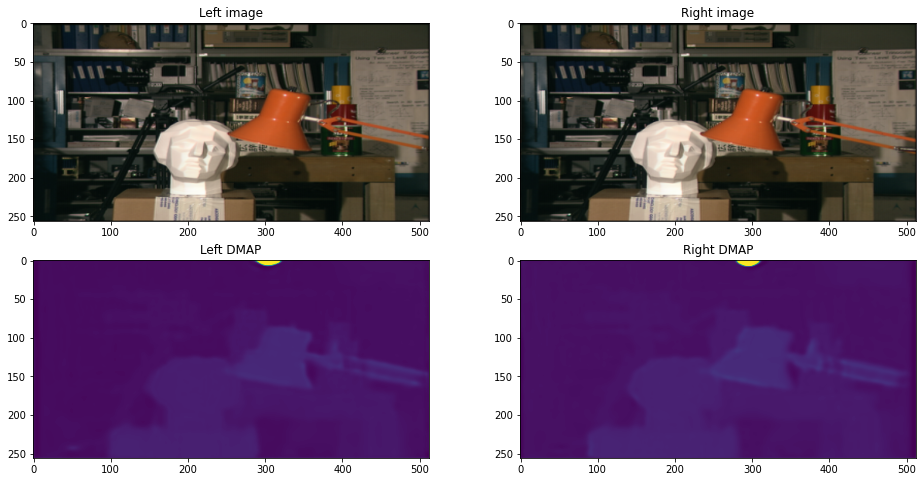

In [25]:
output, sample = test_images(overfit_net, test_dataset, 0)

Pretty good disparity map! I can't get rid of the artifact at the top, not really sure why that's there

# Train on the entire dataset

Time to train on the ~5000 images i have selected

Starting Training with #images:  5280


<IPython.core.display.Javascript object>


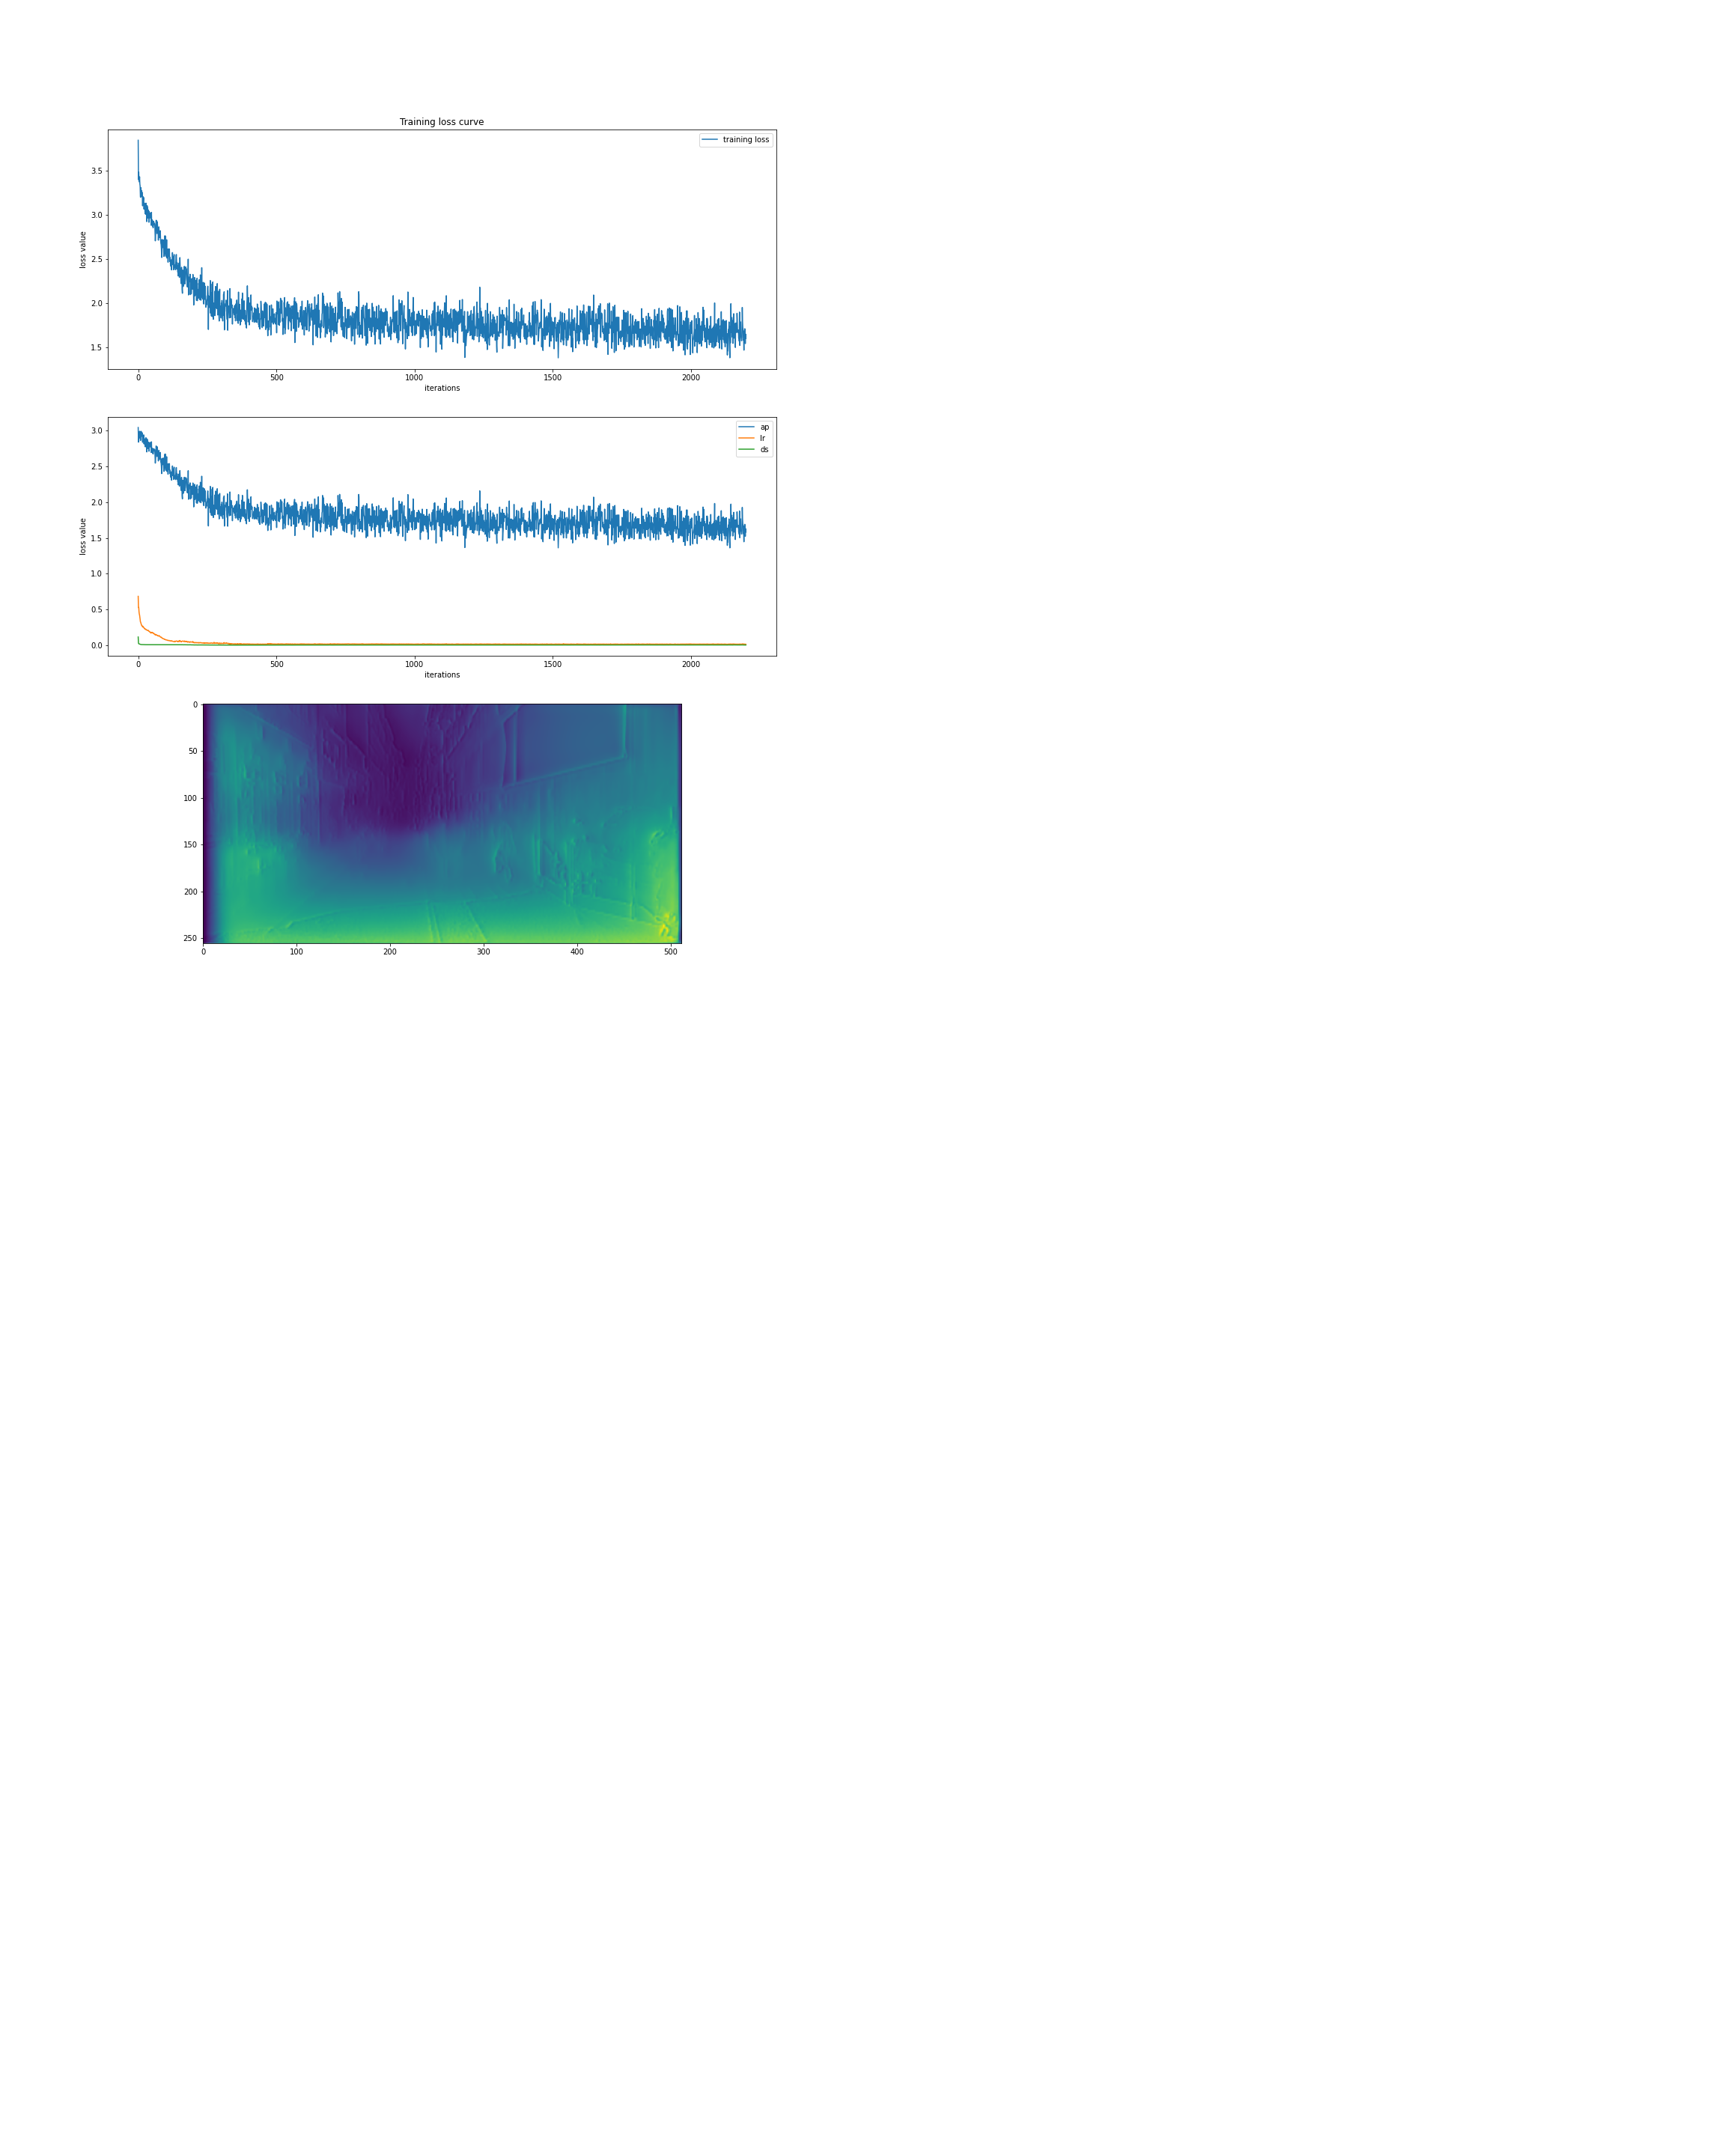

Epoch: 0 Loss: 2.226433038711548
Epoch: 1 Loss: 1.7858818769454956
Epoch: 2 Loss: 1.6092599630355835
Epoch: 3 Loss: 1.936687707901001
Epoch: 4 Loss: 1.479819893836975
Epoch: 5 Loss: 1.4882190227508545
Epoch: 6 Loss: 1.5296359062194824
Epoch: 7 Loss: 1.4799187183380127
Epoch: 8 Loss: 1.416092872619629
Epoch: 9 Loss: 1.6028672456741333
CPU times: user 2h 12min 38s, sys: 4min 48s, total: 2h 17min 27s
Wall time: 33min 57s


In [23]:
%%time
%matplotlib notebook

train_net = MyNet()
train_net.to(device)

# set loss function for the net
train_net.criterion = MonoDepthLoss(device).to(device) # MonodepthLoss().to(device)
loader = train_loader
optimizer = optimizer = torch.optim.Adam(train_net.parameters(), lr=0.01) #1e-4

EPOCH = 10

print("Starting Training with #images: ", len(loader) * loader.batch_size)

loss_graph = []
ap = []
lr = []
ds = []

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(3,1,1)
other = fig.add_subplot(3,1,2)
dmap_plot = fig.add_subplot(3,1,3)

for e in range(EPOCH):
    loss = train(loader, train_net, optimizer, loss_graph, [ap, lr, ds])
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    
    other.clear()
    other.set_xlabel('iterations')
    other.set_ylabel('loss value')
    other.plot(ap, label='ap')
    other.plot(lr, label='lr')
    other.plot(ds, label='ds')
    other.legend(loc='upper right')
    
    output, images = test_images(train_net, val_dataset, 10, False)
    plt.imsave("data/epoch_{}.png".format(e), output[0,0])
    dmap_plot.clear()
    dmap_plot.imshow(output[0,0])
    
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

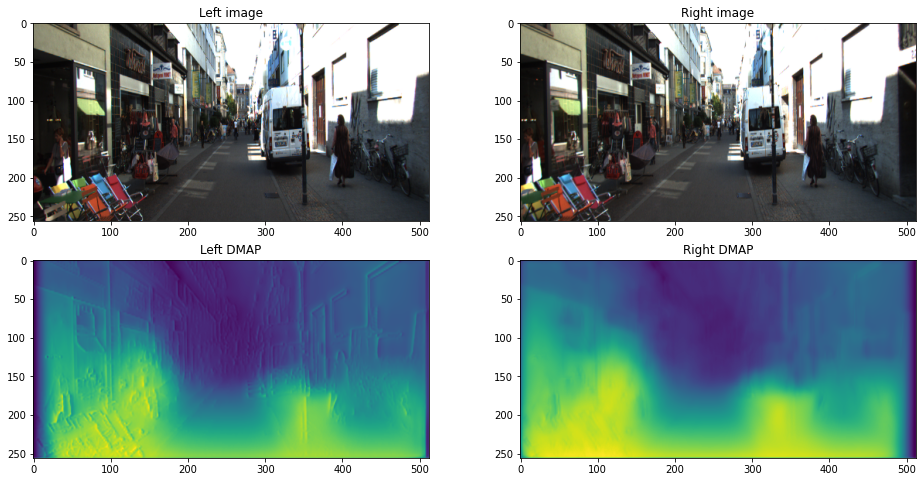

In [27]:
output, images = test_images(train_net, val_dataset, 110)

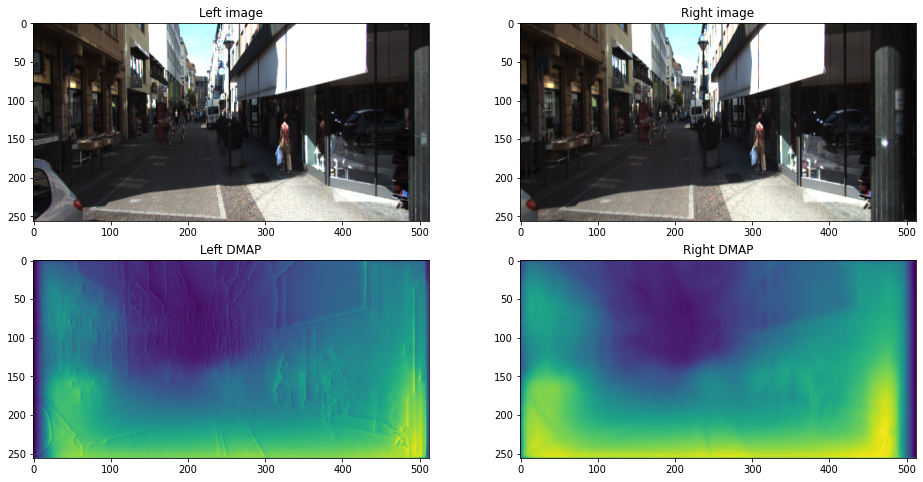

In [28]:
output, images = test_images(train_net, val_dataset, 5)

# Reflection

The model preforms admirably on the unseen validation data after been trained on ~5000 training data for 10 epochs. We can clearly see that closer areas have a higher disparity (brighter) while farther away objects near vanishing points have a low disparity (dark). 

Surprisingly, the left-right consistency loss performed an amazing job of ensuring that the left and right disparity maps are consistent with each other. This allows the network to take advantage of information from both the left and the right image while training.

## Shortcomings:

We can notice in the above examples that the left disparity map have visible boundaries that are probably induced by the gradient smoothness loss function. Discontinuities in the disparity map are not penalized if they align with discontinuities in the input image. Interestingly, the right disparity map does not have the visible boundaries. We probably found two local minima for the gradient smoothness loss portion, one for the left dmap (bad local minima) and one for the right dmap (better, no incorrect boundaries). Reducing the $\alpha_{ds}$, training on more data, and reducing the learning rate would probably remove these artifacts.

We can also see that the appearance matching loss never really converged to a low value, resulting in a blurry disparity map that isn't completely accurate. This is likely due to the small dataset i trained the model on. The original author recommended training on datasets with upwards of 29,000 left-right image pairs (i only used 5,000) for 50 epochs with a learning rate of 0.0001. Of course, such a project isnt feasible for my limited compute power and storage.

Another shortcoming is the disparity ramps on the left of the left disparity map and on the right of the right disparity map. These areas are caused by areas in the left image that do not appear in the right and vice versa. as a result, our appearance loss function can't provide any usable data for those areas. Godard et. al solve this issue to running the model on both the input image and the reflected input image. Once the reflected input image is re-reflected, it will have the disparity ramp on the opposite side of the un-modified image. As a result, these images can be combined to create one image with no disparity ramps. 